In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
from numpy import pi, matmul,sqrt,dot,array,zeros,cos,sin,pi,arccos
from func import OR,heatplot,misorientation,ipfread,classplot,ipfplot,find_neigh
from Class import Data,Cluster,Dataset
import sys
import os
import cv2
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset,DataLoader
import matplotlib.patches as patches

In [2]:
class Dataset:
    def __init__(self,bef,aft,im,im_,dates):
        self.bef=bef
        self.aft=aft
        self.im=im
        self.im_=im_
        self.dates=dates
def create_dataset(root="data/train/"):
    bef=[]
    aft=[]
    im=[]
    im_=[]
    dates=[]
    for date in os.listdir(root):
        path=root+date+"/before/"
        path_=root+date+"/after/"
        bef.append(Data(path));aft.append(Data(path_))
        im.append(ipfread(path)/255.);im_.append(ipfread(path_)/255.)
        dates.append(date)
    return Dataset(bef,aft,im,im_,dates)
# plot phase map wihout filtering crack size > 200
# data=create_dataset("data/780/test/")
# cv2.imwrite("output/780/test/20201109_phase_wofilter.png",data.aft[0].data["Phase"]*255)

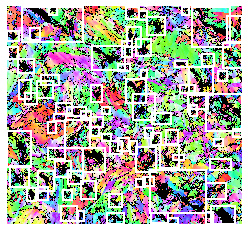

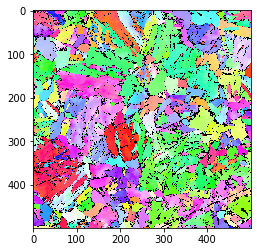

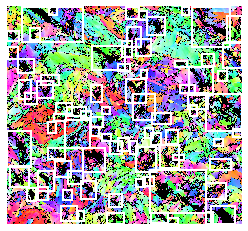

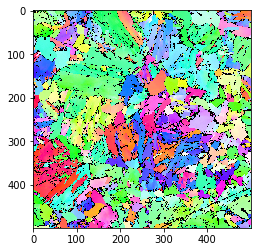

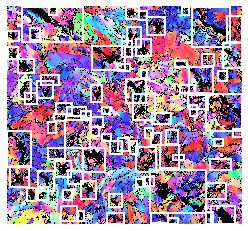

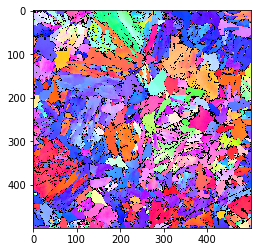

In [12]:
def prepare_location(option):
    # create folder
    root,child,_= option.split("/")
    try:
        os.listdir("output/"+root)
    except:
        os.mkdir("output/"+root)
    try:
        os.listdir("output/"+root+"/"+child)
    except:
        os.mkdir("output/"+root+"/"+child)  
        
    dataset=create_dataset("data/{option}/".format(option=option))
    for index in range(len(dataset.aft)):
        phase=dataset.aft[index].data["Phase"]
        h,w=phase.shape
        cluster=dict()
        ind = 1
        zero_solution=set()
        for i in range(phase.shape[0]):
            for j in range(phase.shape[1]):
                if phase[i,j]==0:
                    zero_solution.add((i,j))
        while len(zero_solution)>0:
            i,j=zero_solution.pop()
            to_travel=set()
            to_travel.add((i,j))
            cluster[ind]=Cluster(ind,i,j)
            while len(to_travel)>0:
                i,j=to_travel.pop()    
                cluster[ind].add(i,j)
                for (k,l) in find_neigh((i,j),h,w):
                    if (k,l) in zero_solution:
                        zero_solution.remove((k,l))
                        to_travel.add((k,l))
            ind+=1
        crack=[]
        phase_aft=np.ones([phase.shape[0],phase.shape[1]])
        for key in range(1,ind):
            if key in cluster:
                if cluster[key].num>200:
                    for (i,j) in cluster[key].pixels:
                        phase_aft[i,j]=0
                    crack.append(key)
        cv2.imwrite("output/{option}{date}_phase.png".format(option=option,date=dataset.dates[index]),phase_aft*255)

        crack_rec = []
        for id in crack:
            sample=np.array(list(cluster[id].pixels))
            top,left=np.min(sample,axis=0)
            bot,right=np.max(sample,axis=0)
            crack_rec.append([top,bot,left,right])
        im = dataset.im[index]
        im_ = dataset.im_[index]
        for j in range(3):
            fig,ax = plt.subplots(1)
            ax.axis('off')
            ax.imshow(im_[:,:,3*j:3*(j+1)][...,[2,1,0]]) # IPF X Y Z
            corner_d = []
            for i in range(len(crack_rec)):
                top,bot,left,right = crack_rec[i]
                try:
                    rect = patches.Rectangle((left,top),right-left,bot-top,linewidth=2,edgecolor='w',facecolor='none')
                    ax.add_patch(rect)
                    corner_d.append([top,left])
                    corner_b.append(p)
                except:
                    pass
            plt.savefig("output/{option}{date}d_IPF{XYZ}.png".format(option=option,date=dataset.dates[index],XYZ=chr(120+j).upper()),dpi=600,bbox_inches='tight',pad_inches=0)
            plt.show()
            fig,ax = plt.subplots(1)
            ax.imshow(dataset.im[index][:,:,3*j:3*(j+1)][...,[2,1,0]])
            cv2.imwrite("output/{option}{date}b_IPF{XYZ}.png".format(option=option,date=dataset.dates[index],XYZ=chr(120+j).upper()),255*dataset.im[index][:,:,3*j:3*(j+1)])
# 要先建立資料夾 ex: output/1180/test/
prepare_location("1180/train/")
# prepare_location("780/train/")
# prepare_location("1180/test/")
# prepare_location("780/val/")
# prepare_location("980/train/")
# prepare_location("980/val/")
# prepare_location("1180/train/")
